# Batch Normalization Keras
Normalize each batch by both mean and variance reference
### Purpose
As the data flows through a deep network, the weights and parameters adjust those values, sometimes making the data too big or too small again - a problem the authors refer to as "internal covariate shift". By normalizing the data in each mini-batch, this problem is largely avoided.

### Benefits:
- Networks train faster converge much more quickly,
- Allows higher learning rates Gradient descent usually requires small learning rates for the network to converge.
- Makes weights easier to initialize
- Makes more activation functions viable Because batch normalization regulates the values going into each activation function, non-linearlities that don't seem to work well in deep networks actually become viable again.
- May give better results overall  it's really an optimization to help train faster, so you shouldn't think of it as a way to make your network better.

### Keypoints
- Batch normalization uses weights as usual, but does NOT add a bias term. This is because, its calculations include gamma and beta variables that make the bias term unnecessary. In Keras `Dense(64, use_bias=False)` or `Conv2D(32, (3, 3), use_bias=False)`
- We add the normalization before calling the activation function.


In [1]:
from tensorflow.python import keras
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

keras.__version__

'2.2.4-tf'

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)  # one-hot
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def data_generator(x, y, batch_size=32):
    batches = int(len(x)/batch_size)
    while 1:
        for i in range(batches):
            yield x[i*batch_size:(i+1)*batch_size], y[i*batch_size:(i+1)*batch_size]

In [0]:
img_size=(28, 28, 1)
class NeuralNet:
    def __init__(self, use_batch_norm, activation='relu'):
        self.use_batch_norm = use_batch_norm
        self.build_model(activation=activation)
    def add_dense_layer(self, units, activation='relu'):
        if self.use_batch_norm:
            self.model.add(layers.Dense(units, use_bias=False))
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Activation(activation))
        else:
            self.model.add(layers.Dense(units, activation=activation))
    def add_conv2d_layer(self, filters, kernel_size, activation='relu', **kwargs):
        if self.use_batch_norm:
            self.model.add(layers.Conv2D(filters, kernel_size, use_bias=False, **kwargs))
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Activation(activation))
        else:
            self.model.add(layers.Conv2D(filters, kernel_size, activation=activation, **kwargs))
    def build_model(self, activation):
        self.model = models.Sequential()
        self.add_conv2d_layer(32, (3, 3), activation=activation, input_shape=img_size)
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.add_conv2d_layer(64, (3, 3), activation=activation)
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.add_conv2d_layer(64, (3, 3), activation=activation)
        self.model.add(layers.Flatten())
        self.add_dense_layer(64, activation=activation)
        self.add_dense_layer(10, activation='softmax')
    def train(self, learning_rate=0.001, epoches=40, batch_size=32, steps_per_epoch=30):
        self.model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
        history = self.model.fit_generator(generator=data_generator(train_images, train_labels, batch_size=batch_size),
                                      steps_per_epoch = steps_per_epoch,
                                      epochs = epoches,
                                      validation_data=data_generator(test_images, test_labels, batch_size=batch_size),
                                      validation_steps=len(test_images)/batch_size)
        return history.history

In [0]:
def plot_training_accuracies(*args, **kwargs):
    """
    Displays a plot of the accuracies calculated during training to demonstrate
    how many iterations it took for the model(s) to converge.
    
    :param args: One or more NeuralNet objects
        You can supply any number of NeuralNet objects as unnamed arguments 
        and this will display their training accuracies. Be sure to call `train` 
        the NeuralNets before calling this function.
    :param kwargs: 
        You can supply any named parameters here, but `steps_per_epoch` is the only
        one we look for. It should match the `steps_per_epoch` value you passed
        to the `train` function.
    """
    fig, ax = plt.subplots()

    steps_per_epoch = kwargs['steps_per_epoch']
    
    for history in args:
        ax.plot(range(0,len(history['acc'])*steps_per_epoch,steps_per_epoch),
                history['acc'], label="acc-" + history['name'])
        ax.plot(range(0,len(history['val_acc'])*steps_per_epoch,steps_per_epoch),
                history['val_acc'], label="val_acc-"+history['name'])
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy During Training')
    ax.legend(loc=4)
    #ax.set_ylim([0,1])
    #plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

    
def train_and_test(learning_rate=0.001, activation="relu", epochs=40, steps_per_epoch=30):
    nn = NeuralNet(use_batch_norm=False, activation=activation)
    bn = NeuralNet(use_batch_norm=True, activation=activation)
    history_nn = nn.train(learning_rate=learning_rate, epoches=epochs, steps_per_epoch=steps_per_epoch)
    history_bn = bn.train(learning_rate=learning_rate, epoches=epochs, steps_per_epoch=steps_per_epoch)
    history_nn['name'] = "Without batch normalization"
    history_bn['name'] = "With batch normalization"
    plot_training_accuracies(history_nn, history_bn, steps_per_epoch=steps_per_epoch)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1/3
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1476 - acc: 0.9556 - val_loss: 0.0952 - val_acc: 0.9673
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0494 - acc: 0.9846 - val_loss: 0.0420 - val_acc: 0.9858
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0345 - acc: 0.9891 - val_loss: 0.0589 - val_acc: 0.9835
Epoch 1/3
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2707 - acc: 0.9624 - val_loss: 0.0743 - val_acc: 0.9875
Epoch 2/3
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0905 - acc: 0.9841 - val_loss: 0.0424 - val_acc: 0.9904
Epoch 3/3
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0497 - acc: 0.9908 - val_loss: 0.0326 - val_acc: 0.9911


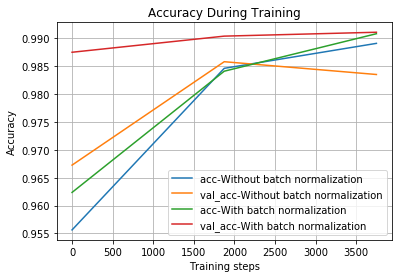

In [6]:
train_and_test(learning_rate=0.001, activation='relu', epochs=3, steps_per_epoch=1875)

Using a sigmoid activation function takes a long time to start learning. It eventually starts making progress, but it took over 250 batches just to get over 70% accuracy. Using batch normalization gets to 90% in around 100 batches.

Epoch 1/3
1875/1875 [==============================] - 16s 8ms/step - loss: 0.5938 - acc: 0.8112 - val_loss: 0.1298 - val_acc: 0.9618
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1045 - acc: 0.9692 - val_loss: 0.0789 - val_acc: 0.9760
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0682 - acc: 0.9793 - val_loss: 0.0768 - val_acc: 0.9765
Epoch 1/3
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3251 - acc: 0.9513 - val_loss: 0.4831 - val_acc: 0.8592
Epoch 2/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1322 - acc: 0.9737 - val_loss: 0.4911 - val_acc: 0.8375
Epoch 3/3
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0852 - acc: 0.9815 - val_loss: 0.4524 - val_acc: 0.8460


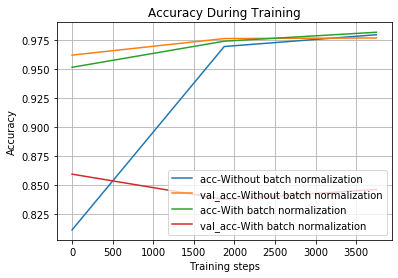

In [7]:
train_and_test(learning_rate=0.001, activation='sigmoid', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1636 - acc: 0.9506 - val_loss: 0.1217 - val_acc: 0.9600
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1036 - acc: 0.9715 - val_loss: 0.0846 - val_acc: 0.9786
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1024 - acc: 0.9737 - val_loss: 0.1165 - val_acc: 0.9696
Epoch 1/3
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1407 - acc: 0.9661 - val_loss: 0.0571 - val_acc: 0.9834
Epoch 2/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0575 - acc: 0.9842 - val_loss: 0.0555 - val_acc: 0.9838
Epoch 3/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0394 - acc: 0.9888 - val_loss: 0.0359 - val_acc: 0.9891


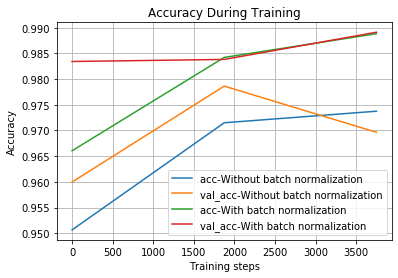

In [8]:
train_and_test(learning_rate=0.01, activation='relu', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================] - 16s 9ms/step - loss: 2.3227 - acc: 0.0993 - val_loss: 2.3105 - val_acc: 0.1136
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 2.3214 - acc: 0.0998 - val_loss: 2.3106 - val_acc: 0.1135
Epoch 3/3
1875/1875 [==============================] - 15s 8ms/step - loss: 2.3214 - acc: 0.0998 - val_loss: 2.3106 - val_acc: 0.1137
Epoch 1/3
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1769 - acc: 0.9552 - val_loss: 0.1297 - val_acc: 0.9589
Epoch 2/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0694 - acc: 0.9802 - val_loss: 0.0798 - val_acc: 0.9738
Epoch 3/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0476 - acc: 0.9865 - val_loss: 0.0495 - val_acc: 0.9841


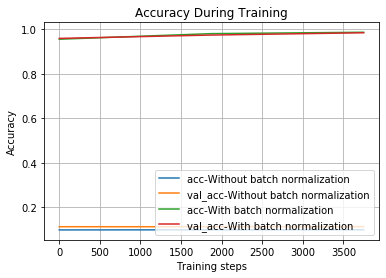

In [9]:
train_and_test(learning_rate=0.01, activation='sigmoid', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================] - 17s 9ms/step - loss: 2.3588 - acc: 0.1053 - val_loss: 2.3068 - val_acc: 0.1028
Epoch 2/3
1875/1875 [==============================] - 15s 8ms/step - loss: 2.3060 - acc: 0.1046 - val_loss: 2.3068 - val_acc: 0.1029
Epoch 3/3
1875/1875 [==============================] - 16s 8ms/step - loss: 2.3060 - acc: 0.1045 - val_loss: 2.3068 - val_acc: 0.1026
Epoch 1/3
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1441 - acc: 0.9584 - val_loss: 0.0934 - val_acc: 0.9708
Epoch 2/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0652 - acc: 0.9802 - val_loss: 0.0830 - val_acc: 0.9754
Epoch 3/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0490 - acc: 0.9857 - val_loss: 0.0461 - val_acc: 0.9846


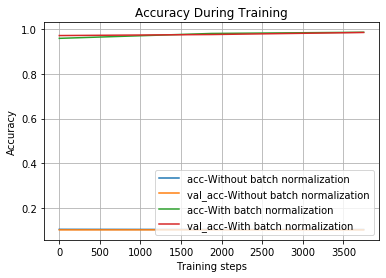

In [10]:
train_and_test(learning_rate=0.05, activation='relu', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================] - 17s 9ms/step - loss: 2.4130 - acc: 0.0974 - val_loss: 2.3308 - val_acc: 0.0957
Epoch 2/3
1875/1875 [==============================] - 16s 8ms/step - loss: 2.4096 - acc: 0.0979 - val_loss: 2.3308 - val_acc: 0.0957
Epoch 3/3
1875/1875 [==============================] - 16s 8ms/step - loss: 2.4097 - acc: 0.0979 - val_loss: 2.3307 - val_acc: 0.0956
Epoch 1/3
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1610 - acc: 0.9530 - val_loss: 0.1641 - val_acc: 0.9490
Epoch 2/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0731 - acc: 0.9782 - val_loss: 0.1110 - val_acc: 0.9659
Epoch 3/3
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0570 - acc: 0.9828 - val_loss: 0.0945 - val_acc: 0.9713


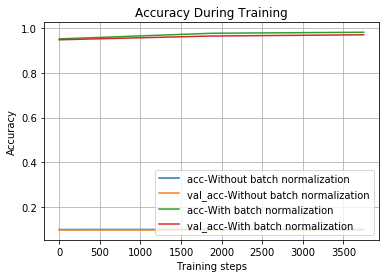

In [11]:
train_and_test(learning_rate=0.05, activation='sigmoid', epochs=3, steps_per_epoch=1875)

Try a smaller steps per epoch

Epoch 1/10
187/187 [==============================] - 5s 24ms/step - loss: 0.6395 - acc: 0.8132 - val_loss: 0.2632 - val_acc: 0.9187
Epoch 2/10
187/187 [==============================] - 3s 15ms/step - loss: 0.2308 - acc: 0.9310 - val_loss: 0.2025 - val_acc: 0.9373
Epoch 3/10
187/187 [==============================] - 3s 15ms/step - loss: 0.1463 - acc: 0.9552 - val_loss: 0.1035 - val_acc: 0.9662
Epoch 4/10
187/187 [==============================] - 3s 15ms/step - loss: 0.1045 - acc: 0.9696 - val_loss: 0.0862 - val_acc: 0.9716
Epoch 5/10
187/187 [==============================] - 3s 15ms/step - loss: 0.0908 - acc: 0.9726 - val_loss: 0.0695 - val_acc: 0.9768
Epoch 6/10
187/187 [==============================] - 3s 15ms/step - loss: 0.0843 - acc: 0.9731 - val_loss: 0.0555 - val_acc: 0.9835
Epoch 7/10
187/187 [==============================] - 3s 15ms/step - loss: 0.0739 - acc: 0.9758 - val_loss: 0.0585 - val_acc: 0.9808
Epoch 8/10
187/187 [==============================] - 3s 15ms/step - 

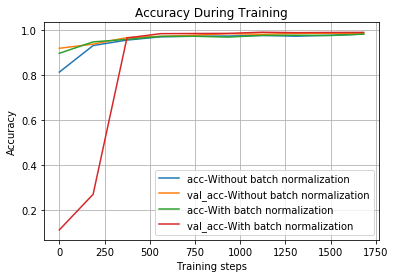

In [12]:
train_and_test(learning_rate=0.001, activation='relu', epochs=10, steps_per_epoch=int(1875/10))